# 1. Installs

In [ ]:
!pip install transformers datasets
# !pip install seaborn

# 2. Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os

import pandas as pd
import numpy as np

import shutil

import re

import matplotlib.pyplot as plt

import seaborn as sns

from datasets import load_dataset, Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

import torch

# 3. Definitions

In [24]:
MODEL_NAME = "roberta-base"  # Английская модель
XLM_MODEL_NAME = "xlm-roberta-base"  # Многоязычная модель
MAX_LENGTH = 256
NUM_CLASSES = 3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42

DATA_DIR = "/content/drive/MyDrive/contradictory-my-dear-watson"
RESULT_DICT = {
        0 : "entailment",
        1 : "neutral",
        2 : "contradiction"}

## 3.1 Config Class

In [10]:
# Disable Weights & Biases tracking and tokenizer parallelism for this session.
os.environ["WANDB_DISABLED"] = "true"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# 4. Load the dataset

In [11]:
for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/contradictory-my-dear-watson/sample_submission.csv
/content/drive/MyDrive/contradictory-my-dear-watson/results/checkpoint-6/config.json
/content/drive/MyDrive/contradictory-my-dear-watson/results/checkpoint-3/optimizer.pt
/content/drive/MyDrive/contradictory-my-dear-watson/results/checkpoint-3/rng_state.pth
/content/drive/MyDrive/contradictory-my-dear-watson/results/checkpoint-3/scaler.pt
/content/drive/MyDrive/contradictory-my-dear-watson/results/checkpoint-3/scheduler.pt
/content/drive/MyDrive/contradictory-my-dear-watson/results/checkpoint-3/trainer_state.json
/content/drive/MyDrive/contradictory-my-dear-watson/results/checkpoint-3/model.safetensors
/content/drive/MyDrive/contradictory-my-dear-watson/results/checkpoint-3/training_args.bin
/content/drive/MyDrive/contradictory-my-dear-watson/results/checkpoint-3/tokenizer_config.json
/content/drive/MyDrive/contradictory-my-dear-watson/results/checkpoint-3/special_tokens_map.json
/content/drive/MyDrive/contradict

In [17]:
train_df = pd.read_csv(DATA_DIR + "/train.csv")
train_df.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [20]:
test_df = pd.read_csv(DATA_DIR + "/test.csv")
test_df.head()

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


In [21]:
def display_pair_of_sentence(x):
    print( "Premise : " + x['premise'])
    print( "Hypothesis: " + x['hypothesis'])
    print( "Language: " + x['language'])
    print( "Label: " + str(x['label']))
    print()

train_df.head(10).apply(lambda x : display_pair_of_sentence(x), axis=1)

Premise : and these comments were considered in formulating the interim rules.
Hypothesis: The rules developed in the interim were put together with these comments in mind.
Language: English
Label: 0

Premise : These are issues that we wrestle with in practice groups of law firms, she said. 
Hypothesis: Practice groups are not permitted to work on these issues.
Language: English
Label: 2

Premise : Des petites choses comme celles-là font une différence énorme dans ce que j'essaye de faire.
Hypothesis: J'essayais d'accomplir quelque chose.
Language: French
Label: 0

Premise : you know they can't really defend themselves like somebody grown uh say my age you know yeah
Hypothesis: They can't defend themselves because of their age.
Language: English
Label: 0

Premise : ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสดงออกและได้เล่นหลายบทบาทไปพร้อมกัน ๆ อาจช่วยให้เด็กจับความคล้ายคลึงและความแตกต่างระหว่างผู้คนในด้านความปรารถนา ความเชื่อ และความรู้สึกได้
Hypothesis: เด็กสามารถเห็นได้ว่าชาติพันธุ

,0
0,None
1,None
2,None
3,None
4,None
5,None
6,None
7,None
8,None
9,None


<ipython-input-25-451bdc6f3387>:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([RESULT_DICT[index] for index in abs_values.index])


Text(0.5, 1.0, 'Distribution of labels in the training set')

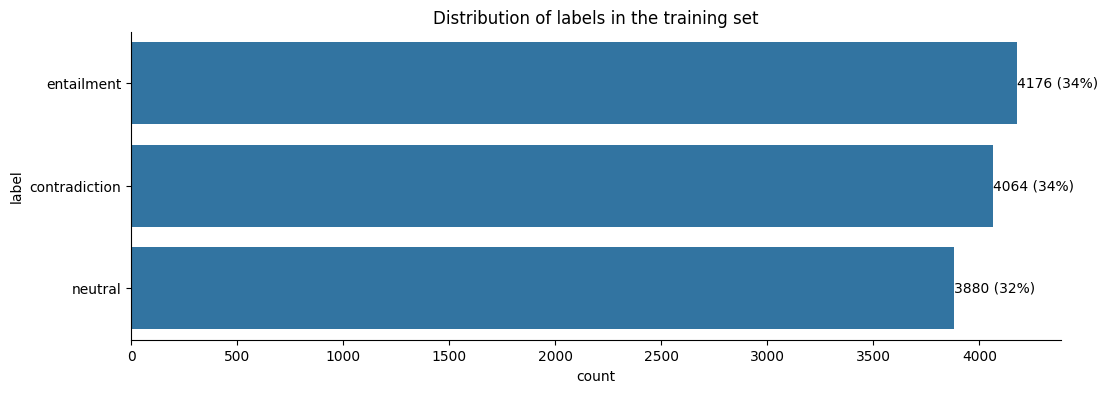

In [25]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(12, 4))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.despine()
ax = sns.countplot(data=train_df,
                   y="label",
                   order = train_df['label'].value_counts().index)

abs_values = train_df['label'].value_counts(ascending=False)
rel_values = train_df['label'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

ax.set_yticklabels([RESULT_DICT[index] for index in abs_values.index])

ax.set_title("Distribution of labels in the training set")

In [26]:
# set number of classes of the label.
NUM_CLASSES = 3

Text(0.5, 1.0, 'Distribution of languages in the training set')

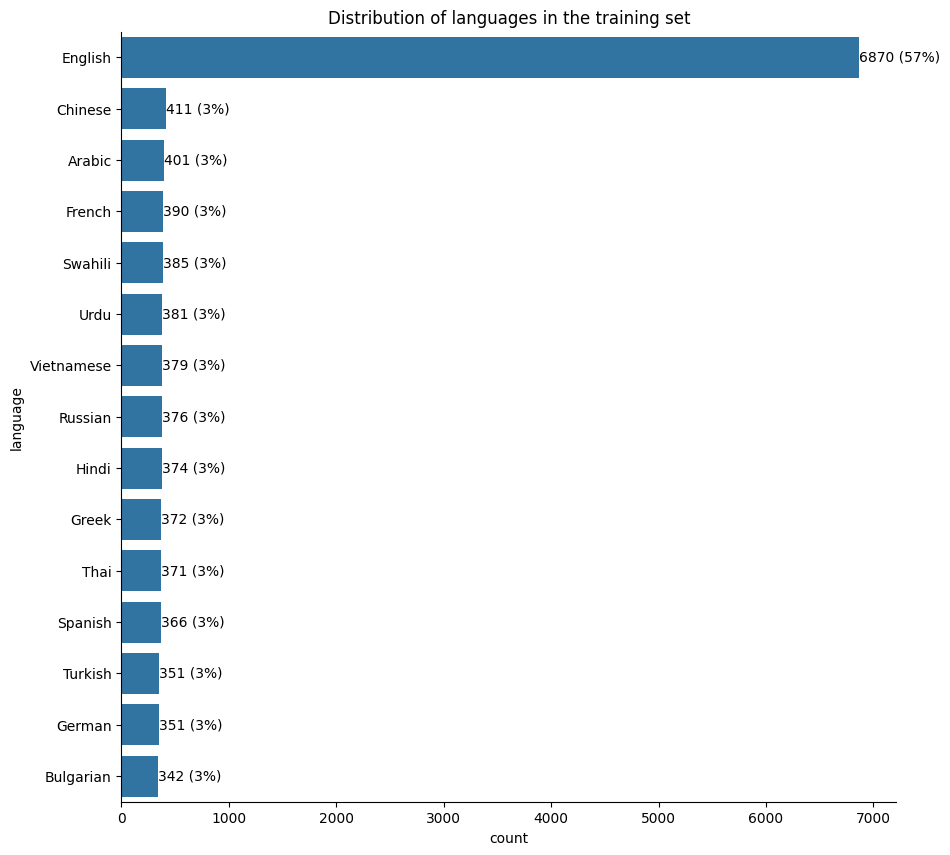

In [27]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.despine()
ax = sns.countplot(data=train_df,
                   y="language",
                   order = train_df['language'].value_counts().index)

abs_values = train_df['language'].value_counts(ascending=False)
rel_values = train_df['language'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

ax.set_title("Distribution of languages in the training set")

In [28]:
# Distribution of languages in the dataset
language_counts = train_df['language'].value_counts()
print("Language distribution:")
print(language_counts)

Language distribution:
language
English       6870
Chinese        411
Arabic         401
French         390
Swahili        385
Urdu           381
Vietnamese     379
Russian        376
Hindi          374
Greek          372
Thai           371
Spanish        366
Turkish        351
German         351
Bulgarian      342
Name: count, dtype: int64


In [29]:
# Split the dataset into English and non-English subsets
english_df = train_df[train_df['language'] == 'English']
non_english_df = train_df[train_df['language'] != 'English']

In [30]:
# Split the dataset into English and non-English subsets
english_test_df = test_df[test_df['language'] == 'English']
non_english_test_df = test_df[test_df['language'] != 'English']

In [31]:
print(f"\nEnglish subset: {len(english_df)} samples")
print(f"Non-English subset: {len(non_english_df)} samples")


English subset: 6870 samples
Non-English subset: 5250 samples


In [32]:
# text samples
train_df[['premise', 'hypothesis']].sample(5)

# check missing values
print("Missing values:\n", train_df[['premise', 'hypothesis']].isnull().sum())

# check wird chars

train_df['special_chars'] = train_df['premise'].apply(lambda x: re.findall(r'[^\w\s]', x))
print("Samples of text with special chars:\n", train_df[['premise', 'special_chars']].head())

Missing values:
 premise       0
hypothesis    0
dtype: int64
Samples of text with special chars:
                                              premise  \
0  and these comments were considered in formulat...   
1  These are issues that we wrestle with in pract...   
2  Des petites choses comme celles-là font une di...   
3  you know they can't really defend themselves l...   
4  ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...   

                                       special_chars  
0                                                [.]  
1                                             [,, .]  
2                                          [-, ', .]  
3                                                [']  
4  [่, ุ, ิ, ็, ่, ั, ี, ่, ้, ้, ่, ้, ั, ่, ้, ...  


<ipython-input-36-a90d815d7d5c>:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([RESULT_DICT[index] for index in abs_values.index])


Text(0.5, 1.0, 'Distribution of labels in the training set')

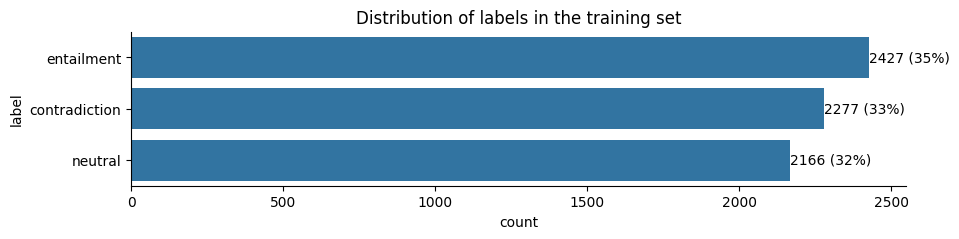

In [36]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 2))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.despine()
ax = sns.countplot(data=english_df,
                   y="label",
                   order = english_df['label'].value_counts().index)

abs_values = english_df['label'].value_counts(ascending=False)
rel_values = english_df['label'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

ax.set_yticklabels([RESULT_DICT[index] for index in abs_values.index])

ax.set_title("Distribution of labels in the training set")